# Anexo 7


### 0. Enlaces de interes

1. How to run nnU-Net on a new dataset:  https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md
2. Class merging: Region-based training: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/region_based_training.md
3. Establish number of epoch using class Trainer: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunetv2/training/nnUNetTrainer/variants/training_length/nnUNetTrainer_Xepochs.py
4. Articles how to use nnUnet with example:

https://transformhealthcare.medium.com/th-3-glioblastoma-brain-tumor-segmentation-part-1-7f9e406526f7
https://transformhealthcare.medium.com/glioblastoma-brain-tumor-segmentation-part-3-preparing-the-environment-9d05a7a0fe64
https://transformhealthcare.medium.com/glioblastoma-brain-tumor-segmentation-part-4-data-setup-b8dbea11473b
https://transformhealthcare.medium.com/glioblastoma-brain-tumor-segmentation-part-5-data-preprocessing-46022f101ad0
https://transformhealthcare.medium.com/glioblastoma-brain-tumor-segmentation-part-6-neural-network-model-training-5de238e9b195
https://transformhealthcare.medium.com/glioblastoma-brain-tumor-segmentation-part-7-inference-58d4287a040d


## 1.  Instalaciones necesarias


In [ ]:
%%capture
!pip install nnunetv2

In [ ]:
%%capture
!pip install SimpleITK

In [ ]:
import torch
import nibabel as nib
import numpy as np
import pandas as pd
import os
import pathlib
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import SimpleITK as sitk
from matplotlib.colors import ListedColormap

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET = "Dataset003_ToothFairy2"
ID_DATASET="003"
MAIN_DIR='/content/drive/MyDrive/saros/nnUNet'

FOLDER_IMAGES_TEST = MAIN_DIR + '/nnUNet_raw/' + DATASET + '/imagesTs'
FOLDER_LABELS_TEST_GT = MAIN_DIR + '/nnUNet_raw/' + DATASET + '/labelsTs'
FOLDER_LABELS_TEST_PREDICTIONS = MAIN_DIR + '/nnUNet_results/' + DATASET + '/postprocessing'
FOLDER_INFERENCE = MAIN_DIR + '/nnUNet_results/' + DATASET + '/inference'
DJFILE_TEST_PREDICTIONS = MAIN_DIR +'/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/dataset.json'
PFILE_TEST_PREDICTIONS = MAIN_DIR + '/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/plans.json'
FOLDER_CROSS_VAL = MAIN_DIR + '/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4/'
FOLDER_VAL = MAIN_DIR + '/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/'
PKL_FILW = MAIN_DIR + '/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4/postprocessing.pkl'
PLN_JSON = MAIN_DIR + '/nnUNet_results/' + DATASET + '/nnUNetTrainer_20epochs__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4/plans.json'

In [ ]:
import os
os.environ["nnUNet_raw"]= MAIN_DIR + "/nnUNet_raw"
os.environ["nnUNet_preprocessed"]= MAIN_DIR + "/nnUNet_preprocessed"
os.environ["nnUNet_results"]= MAIN_DIR + "/nnUNet_results"

## 2. Preprocesamiento de imagenes

Preprocesamiento solo se ejecuta 1 vez para cada dataset, los resultados se guardan en la carpeta "nnUNet_preprocessed"

In [ ]:
!nnUNetv2_plan_and_preprocess -d $ID_DATASET --verify_dataset_integrity

Fingerprint extraction...
Dataset003_ToothFairy2
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 1620/1620 [01:50<00:00, 14.68it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 16, 'patch_size': (448, 448), 'median_image_size_in_voxels': array([410., 410.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization'], 'use

## 3. Entrenamiento

### 3.1 Clase de entrenador personalizada

Para solucionar el problema de tener un número predeterminado de 1000 épocas en nnUNet, se crea una nueva clase de entrenador personalizada llamada "nnUNetTrainer_20epochs". Esta clase hereda las propiedades de la clase original, pero sobrescribe el número de épocas, estableciéndolo en 20. Para mas opciones mirar https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunetv2/training/nnUNetTrainer/variants/training_length/nnUNetTrainer_Xepochs.py

In [ ]:
from nnunetv2.training.nnUNetTrainer.nnUNetTrainer import nnUNetTrainer

class nnUNetTrainer_20epochs(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 20

### 3.2 Entrenamiento con folds 0-4

En nnUNet no se utiliza un conjunto de validación tradicional. En lugar de eso, se emplea una validación cruzada con 5 folds. Esto significa que el entrenamiento se ejecuta cinco veces, cada vez utilizando un fold diferente como conjunto de validación y los otros cuatro folds como conjunto de entrenamiento. Este enfoque ayuda a evaluar la robustez y la generalización del modelo.

Al ejecutar el entrenamiento, especificamos cada uno de los folds. Además, indicamos el parámetro --npz, que le dice a nnUNet que almacene las salidas softmax durante la validación final. Esto es necesario porque, después del entrenamiento, vamos a pedirle a nnUNet que elija la mejor configuración.


Los tiempos de entrenamiento dependen en gran medida de la GPU. La GPU más pequeña que se recomienda para entrenar es la Nvidia RTX 2080ti.

#### Fold 0

train_los y val_loss son negativos, pero dicen que es normal https://github.com/MIC-DKFZ/nnUNet/issues/662

In [ ]:
!nnUNetv2_train $DATASET 2d 0 --npz -tr nnUNetTrainer_20epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-05-29 14:18:42.868694: do_dummy_2d_data_aug: False
2024-05-29 14:18:57.948336: Using splits from existing split file: /content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed/Dataset003_ToothFairy2/splits_final.json
2024-05-29 14:18:58.172326: The split file contains 5 splits.
2024-05-29 14:

#### Fold 1

In [ ]:
!nnUNetv2_train $DATASET 2d 1 --npz -tr nnUNetTrainer_20epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-05-29 15:57:46.505571: do_dummy_2d_data_aug: False
2024-05-29 15:57:46.617640: Using splits from existing split file: /content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed/Dataset003_ToothFairy2/splits_final.json
2024-05-29 15:57:46.624138: The split file contains 5 splits.
2024-05-29 15:

#### Fold 2

In [ ]:
!nnUNetv2_train $DATASET 2d 2 --npz -tr nnUNetTrainer_20epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-06-03 06:07:42.301799: do_dummy_2d_data_aug: False
2024-06-03 06:08:16.072783: Using splits from existing split file: /content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed/Dataset003_ToothFairy2/splits_final.json
2024-06-03 06:08:16.714777: The split file contains 5 splits.
2024-06-03 06:

#### Fold 3

In [ ]:
!nnUNetv2_train $DATASET 2d 3 --npz -tr nnUNetTrainer_20epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-06-03 07:28:04.190331: do_dummy_2d_data_aug: False
2024-06-03 07:28:04.278094: Using splits from existing split file: /content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed/Dataset003_ToothFairy2/splits_final.json
2024-06-03 07:28:04.283244: The split file contains 5 splits.
2024-06-03 07:

#### Fold 4

In [ ]:
!nnUNetv2_train $DATASET 2d 4 --npz -tr nnUNetTrainer_20epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-06-03 08:38:57.600699: do_dummy_2d_data_aug: False
2024-06-03 08:38:57.706530: Using splits from existing split file: /content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed/Dataset003_ToothFairy2/splits_final.json
2024-06-03 08:38:57.721524: The split file contains 5 splits.
2024-06-03 08:

### 3.3 Encontrar la mejor configuración de entrenamiento

In [ ]:
os.environ["nnUNet_raw"]="/content/drive/MyDrive/saros/nnUNet/nnUNet_raw"
os.environ["nnUNet_preprocessed"]="/content/drive/MyDrive/saros/nnUNet/nnUNet_preprocessed"
os.environ["nnUNet_results"]="/content/drive/MyDrive/saros/nnUNet/nnUNet_results"

In [ ]:
!nnUNetv2_find_best_configuration $DATASET -c 2d -tr nnUNetTrainer_20epochs


***All results:***
nnUNetTrainer_20epochs__nnUNetPlans__2d: 0.6590055799540793

*Best*: nnUNetTrainer_20epochs__nnUNetPlans__2d: 0.6590055799540793

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.97726 after: 0.78857
Removing all but the largest component for 2 did not improve results! Dice before: 0.89794 after: 0.8578
Removing all but the largest component for (11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48) did not improve results! Dice before: 0.0 after: 0.0
Results were improved by removing all but the largest component for (3, 4, 5, 6, 7, 8, 9, 10, 18, 19, 20, 29, 30, 38, 39, 40). Dice before: 0.76082 after: 0.80861

***Run inference like this:***

nnUNetv2_predict -d Dataset003_ToothFairy2 -i INPUT_FOLDER -o OUTPUT_FOLDER -f  0 1 2 3 4

### 3.4. Resultados de entrenamiento

NnUNet no proporciona una función específica para visualizar métricas de entrenamiento en tiempo real, pero guarda estos datos en archivos de registro.

**Dice score**

Por ejemplo los datos en el archivo "summary.json" en la carpeta "crossval_results_folds_0_1_2_3_4" contienen las métricas de evaluación del entrenamiento cruzado.

In [ ]:
directorio = FOLDER_CROSS_VAL

# Ruta al archivo summary.json
nombre_archivo = 'summary.json'
# Unir directorio y nombre del archivo
summary_file = os.path.join(directorio, nombre_archivo)

def load_summary(json_path):
    with open(json_path, 'r') as file:
        summary = json.load(file)
    return summary

def display_combined_metrics_table(foreground_metrics, class_metrics):
    # Crear DataFrames individuales para cada conjunto de métricas
    df_foreground = pd.DataFrame(foreground_metrics, index=['promedio de clases'])
    df_class = pd.DataFrame(class_metrics, index=['mandibula'])

    # Combinar los DataFrames
    combined_df = pd.concat([df_foreground, df_class])
    return combined_df

# Cargar las métricas del archivo JSON
summary = load_summary(summary_file)

# Extraer las métricas de foreground_mean
foreground_mean = summary['foreground_mean']

# Extraer las métricas de 'mean' para la clase "1"
mandibula_mean = summary['mean']['1']  # clase 1 - lower jawbone

# Mostrar las métricas combinadas en una tabla
metrics_table = display_combined_metrics_table(foreground_mean, mandibula_mean)
metrics_table

,Dice,FN,FP,IoU,TN,TP,n_pred,n_ref
promedio de clases,0.659006,569.112346,556.068981,0.619335,163982.183488,2992.635185,3548.704167,3561.747531
mandibula,0.977265,84.379630,146.341975,0.959395,161713.437654,6155.840741,6302.182716,6240.220370


**Curvas de entrenamiento**

En cada fold de la carpeta nnUNetTrainer_20epochs__nnUNetPlans__2d se guardan los resultados de entrenamiento (evalucion de Dice con epocas) en los ficheros "progress.png"

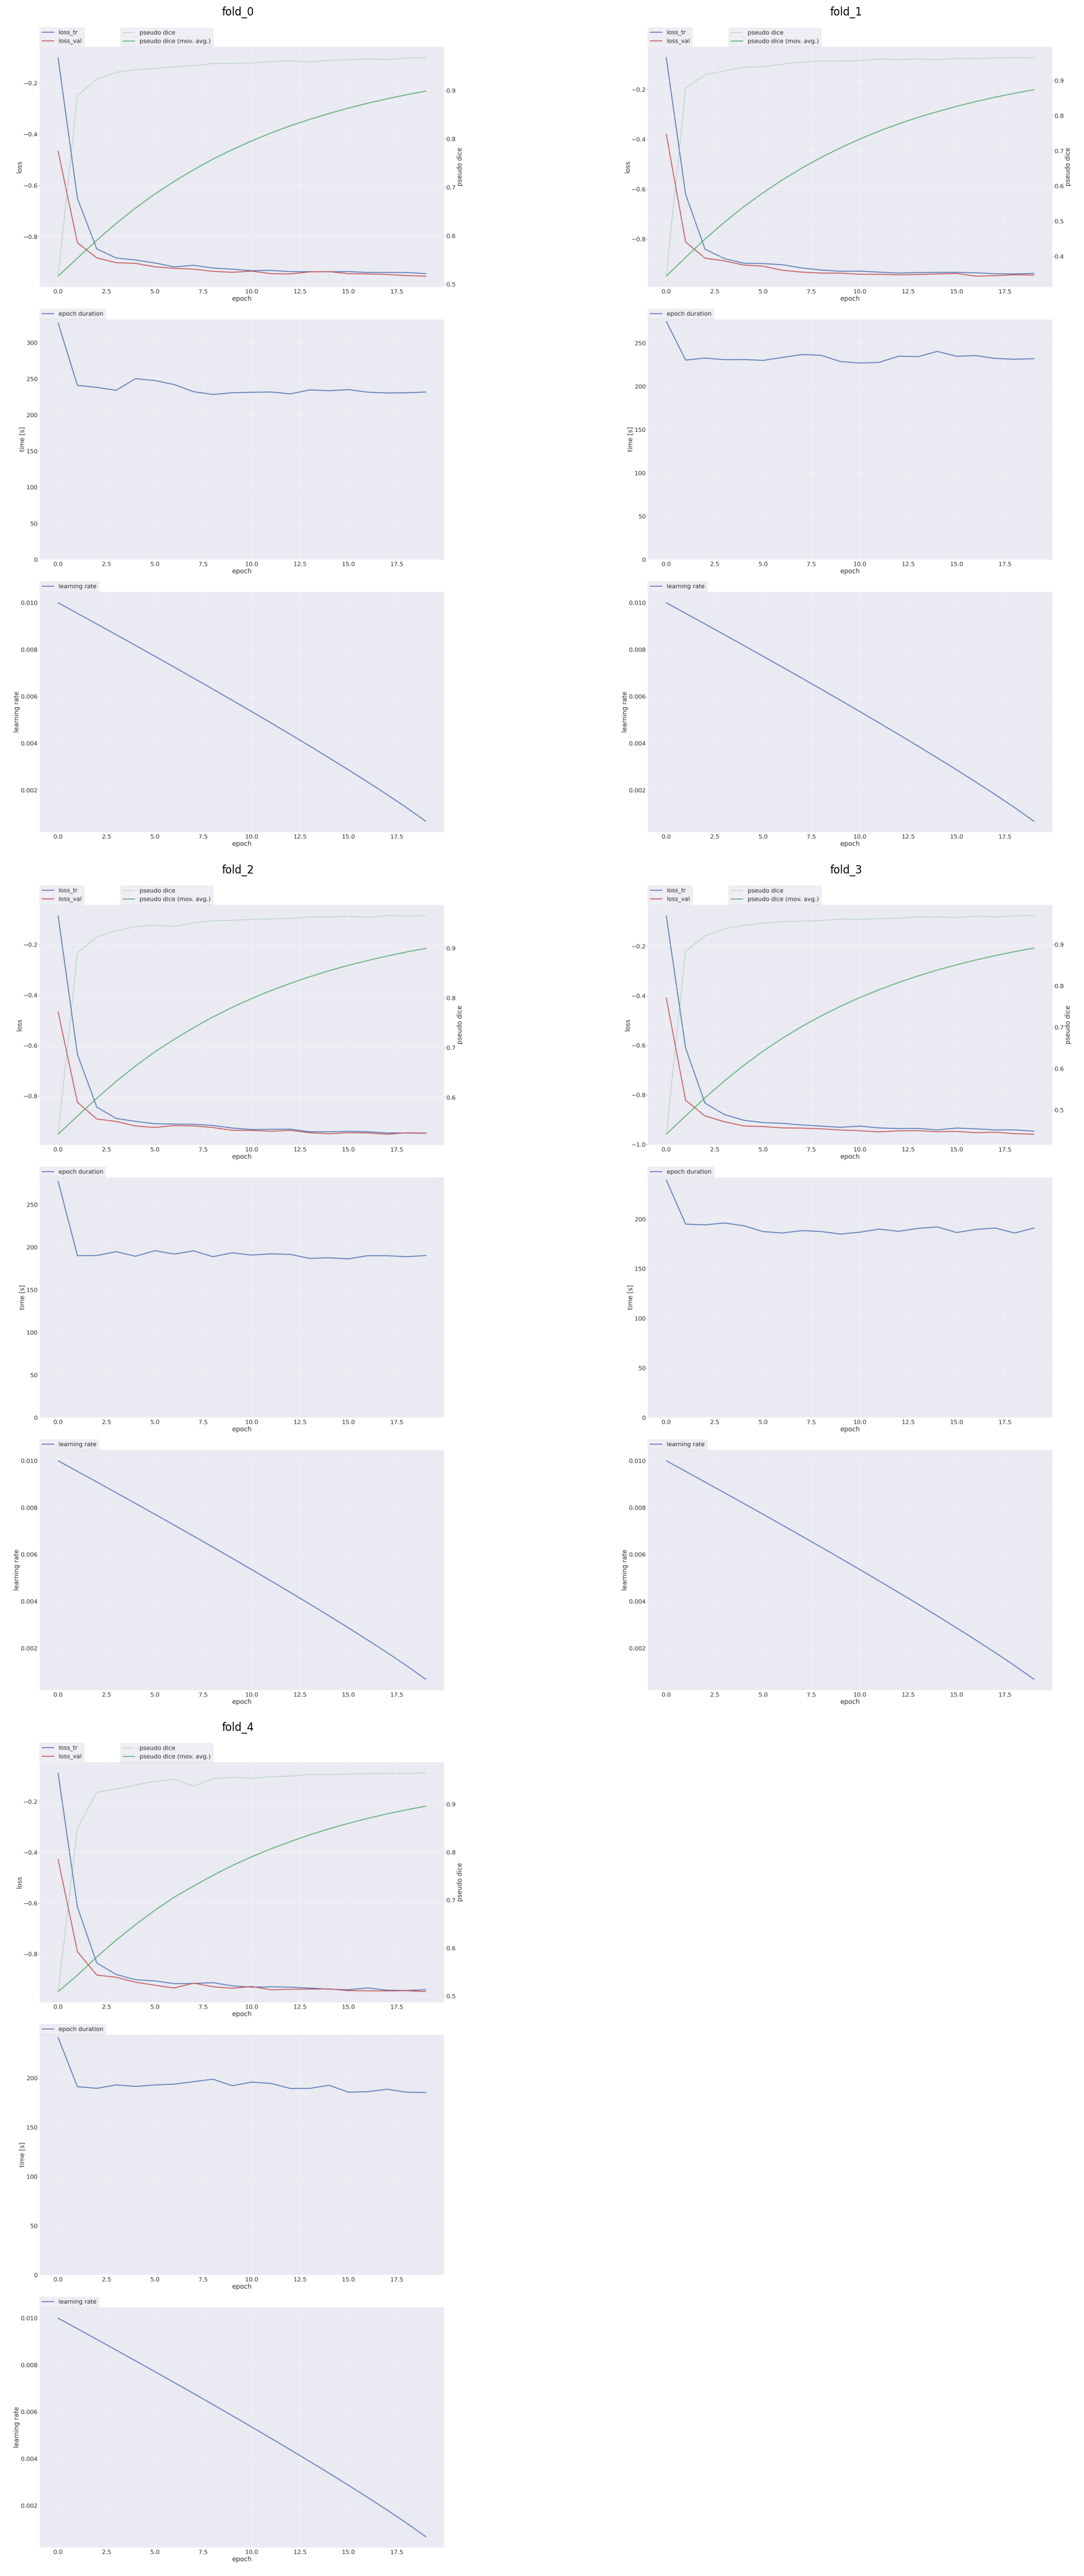

In [ ]:
file="progress.png"
folders=["fold_" + str(x) for x in range(5)]
# create figure
fig = plt.figure(figsize=(20, 40))

# setting values to rows and column variables
rows = 3
columns = 2
for  i, fold in enumerate(folders):
  ruta= FOLDER_VAL + fold
  file_path=os.path.join(ruta,file)
  img = mpimg.imread(file_path)
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(fold)

plt.tight_layout()
plt.show()

## 4. Predicción utilizando conjunto de test

### 4.1 Inferencia

Realizamos predicciones utilizando un modelo previamente entrenado en el conjunto de datos utilisando clase de entrenador personalizado. Guardamos los resultados en la carpeta "inferencia"

In [ ]:
!nnUNetv2_predict -d $DATASET -i $FOLDER_IMAGES_TEST -o $FOLDER_INFERENCE -f  0 1 2 3 4 -tr nnUNetTrainer_20epochs -c 2d -p nnUNetPlans

Se han truncado las últimas 5000 líneas del flujo de salida.

Predicting ToothFairy2F_051048:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 28.42it/s]
100% 1/1 [00:00<00:00, 28.69it/s]
100% 1/1 [00:00<00:00, 30.36it/s]
100% 1/1 [00:00<00:00, 30.31it/s]
100% 1/1 [00:00<00:00, 30.43it/s]
sending off prediction to background worker for resampling and export
done with ToothFairy2F_051048

Predicting ToothFairy2F_051049:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 24.57it/s]
100% 1/1 [00:00<00:00, 27.24it/s]
100% 1/1 [00:00<00:00, 30.48it/s]
100% 1/1 [00:00<00:00, 30.91it/s]
100% 1/1 [00:00<00:00, 30.46it/s]
sending off prediction to background worker for resampling and export
done with ToothFairy2F_051049

Predicting ToothFairy2F_051050:
perform_everything_on_device: True
100% 1/1 [00:00<00:00, 28.80it/s]
100% 1/1 [00:00<00:00, 27.75it/s]
100% 1/1 [00:00<00:00, 28.94it/s]
100% 1/1 [00:00<00:00, 21.67it/s]
100% 1/1 [00:00<00:00, 30.52it/s]
sending off prediction to

### 4.2 Postprocesamiento


Ahora ejecutemos el paso de postprocesamiento para generar los archivos de segmentación final utilizando el mejor modelo determinado por nnUNet en función del puntaje DICE. La carpeta de entrada es nuestra carpeta de "inferencia", y la carpeta de salida es una carpeta "postprocesamiento".

In [ ]:
!nnUNetv2_apply_postprocessing -i $FOLDER_INFERENCE -o $FOLDER_LABELS_TEST_PREDICTIONS -pp_pkl_file $PKL_FILW -np 8 -plans_json $PLN_JSON

### 4.3. Resultados de test

Evaluamos  las predicciones realizadas por nnUNet comparándolas con las etiquetas verdaderas

In [ ]:
!nnUNetv2_evaluate_folder $FOLDER_LABELS_TEST_GT $FOLDER_LABELS_TEST_PREDICTIONS -djfile $DJFILE_TEST_PREDICTIONS -pfile $PFILE_TEST_PREDICTIONS

# Ruta al archivo summary.json
nombre_archivo = 'summary.json'
# Unir directorio y nombre del archivo
summary_test_file = os.path.join(FOLDER_LABELS_TEST_PREDICTIONS, nombre_archivo)


# Cargar las métricas del archivo JSON
summary_test = load_summary(summary_test_file)

# Extraer las métricas de foreground_mean
foreground_mean = summary_test['foreground_mean']

# Extraer las métricas de 'mean' para la clase "1"
mandibula_mean = summary_test['mean']['1']

# Mostrar las métricas combinadas en una tabla
metrics_table = display_combined_metrics_table(foreground_mean, mandibula_mean)
metrics_table

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer


,Dice,FN,FP,IoU,TN,TP,n_pred,n_ref
promedio de clases,0.660252,937.576642,125.416515,0.622420,164109.619526,2927.387318,3052.803832,3864.963960
mandibula,0.953292,143.260949,202.572993,0.926415,161765.932482,5988.233577,6190.806569,6131.494526


### 4.4 Visualisaciones: imagen de test, etiqueta original y etiqueta predicha

In [ ]:
def show_two_nii_images(file_name1, file_name2, file_name3, ruta_imagen_test, ruta_label_test, ruta_label_predicho):
    """
    Muestra dos imágenes .nii.gz en una sola línea.

    Args
        file_name1 (str): imagen de test.nii.gz (sin ruta).
        file_name2 (str): label de test .nii.gz (sin ruta).
        file_name3 (str): label predicho .nii.gz (sin ruta).
        slice_index (int): Índice de la slice a mostrar (por defecto es 0).
    """
    # Directorios predeterminados
    image_dir1 = ruta_imagen_test
    image_dir2 = ruta_label_test
    image_dir3 = ruta_label_predicho

    # Construir las rutas completas de los archivos
    image_path1 = os.path.join(image_dir1, file_name1)
    image_path2 = os.path.join(image_dir2, file_name2)
    image_path3 = os.path.join(image_dir3, file_name3)

    print(image_path1)
    print(image_path2)
    print(image_path3)

    # Leer imágenes
    image1 = sitk.ReadImage(image_path1)
    image2 = sitk.ReadImage(image_path2)
    image3 = sitk.ReadImage(image_path3)

    # Convertir las imágenes a arrays numpy y reformatear
    image_array1 = sitk.GetArrayFromImage(image1)
    image_array2 = sitk.GetArrayFromImage(image2)
    image_array3 = sitk.GetArrayFromImage(image3)

    # Colores distintivos para las clases originales
    color_map_dict = ['black', 'red', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange',
                  'green', 'green', 'green', 'green', 'green', 'green', 'green',
                  'orange', 'orange', 'orange', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']
    cmap_original = ListedColormap(color_map_dict)

    # Colores distintivos para las clases nuevos
    cmap = ListedColormap(['black','red', 'blue', 'green', 'orange'])

   # Mostrar las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusta el tamaño de la figura
    plt.subplots_adjust(wspace=0.3)  # Ajusta el espaciado entre subgráficos

    # Primera imagen
    axes[0].imshow(image_array1, cmap='gray')  # Muestra la imagen en escala de grises
    axes[0].set_title('Imagen de Test')

    # Segunda imagen
    axes[1].imshow(image_array2, cmap=cmap_original, vmin=0, vmax=48)  # Muestra la imagen de label de test
    axes[1].set_title('Etiqueta original')

    # Tercera imagen
    im = axes[2].imshow(image_array3, cmap=cmap, vmin=0, vmax=4)  # Muestra la imagen de label predicho
    axes[2].set_title('Etiqueta predicha')

    # Crear y mostrar leyenda independiente
    legend_labels = ['Background', 'Lower Jawbone', 'Upper Jawbone', 'Teeth', 'Resto']
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1, 2, 3, 4], orientation='vertical', label='Clase')
    cbar.ax.set_yticklabels(legend_labels)

    plt.show()

/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTs/ToothFairy2F_051050_0000.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTs/ToothFairy2F_051050.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_results/Dataset003_ToothFairy2/postprocessing/ToothFairy2F_051050.nii.gz


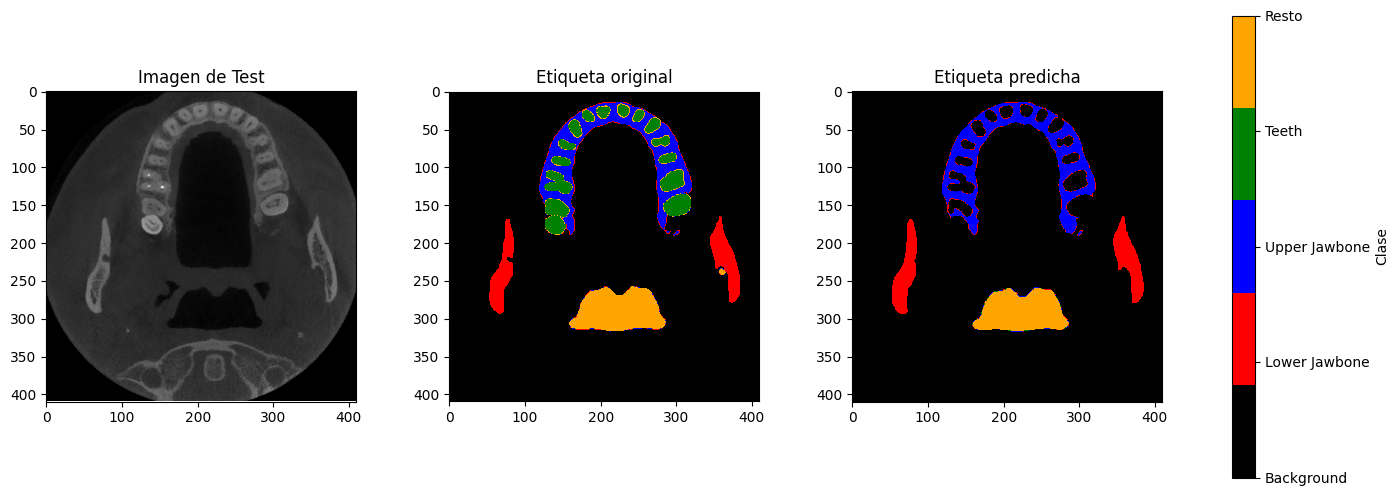

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_051050_0000.nii.gz'
file_name2 = 'ToothFairy2F_051050.nii.gz'
file_name3 = 'ToothFairy2F_051050.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, FOLDER_IMAGES_TEST, FOLDER_LABELS_TEST_GT, FOLDER_LABELS_TEST_PREDICTIONS)

/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTs/ToothFairy2F_051100_0000.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTs/ToothFairy2F_051100.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_results/Dataset003_ToothFairy2/postprocessing/ToothFairy2F_051100.nii.gz


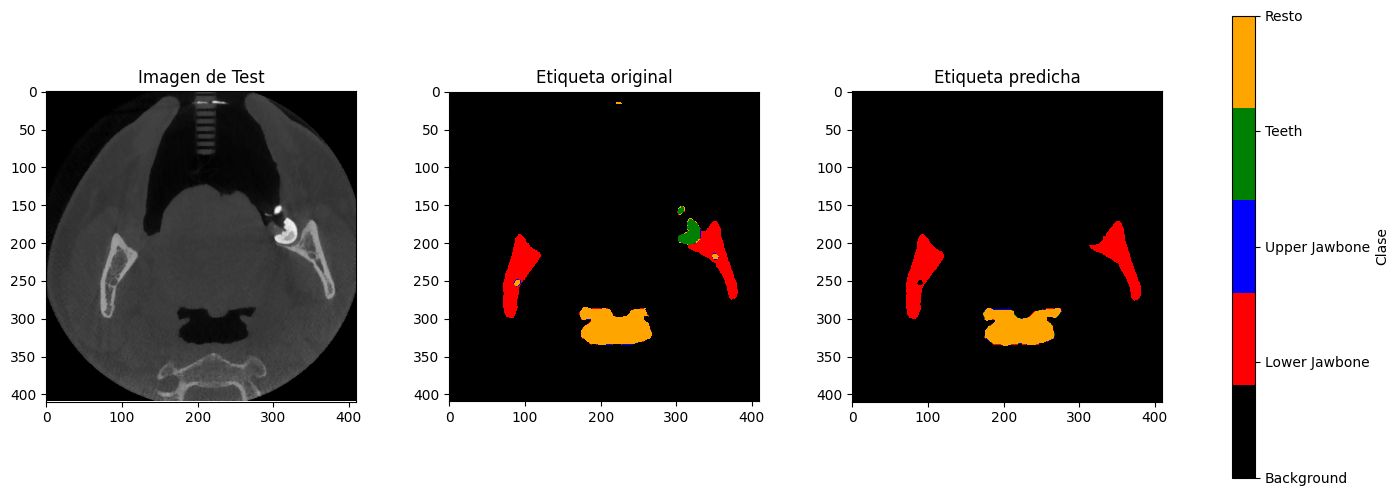

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_051100_0000.nii.gz'
file_name2 = 'ToothFairy2F_051100.nii.gz'
file_name3 = 'ToothFairy2F_051100.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, FOLDER_IMAGES_TEST, FOLDER_LABELS_TEST_GT, FOLDER_LABELS_TEST_PREDICTIONS)

/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTs/ToothFairy2F_051150_0000.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTs/ToothFairy2F_051150.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_results/Dataset003_ToothFairy2/postprocessing/ToothFairy2F_051150.nii.gz


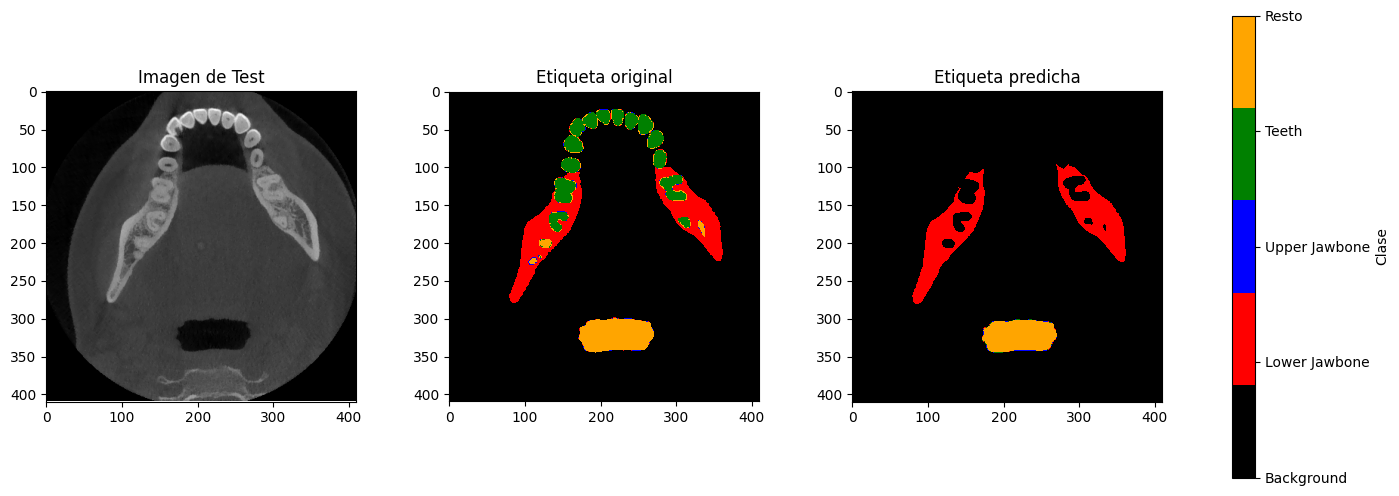

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_051150_0000.nii.gz'
file_name2 = 'ToothFairy2F_051150.nii.gz'
file_name3 = 'ToothFairy2F_051150.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, FOLDER_IMAGES_TEST, FOLDER_LABELS_TEST_GT, FOLDER_LABELS_TEST_PREDICTIONS)

/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTs/ToothFairy2F_051200_0000.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTs/ToothFairy2F_051200.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_results/Dataset003_ToothFairy2/postprocessing/ToothFairy2F_051200.nii.gz


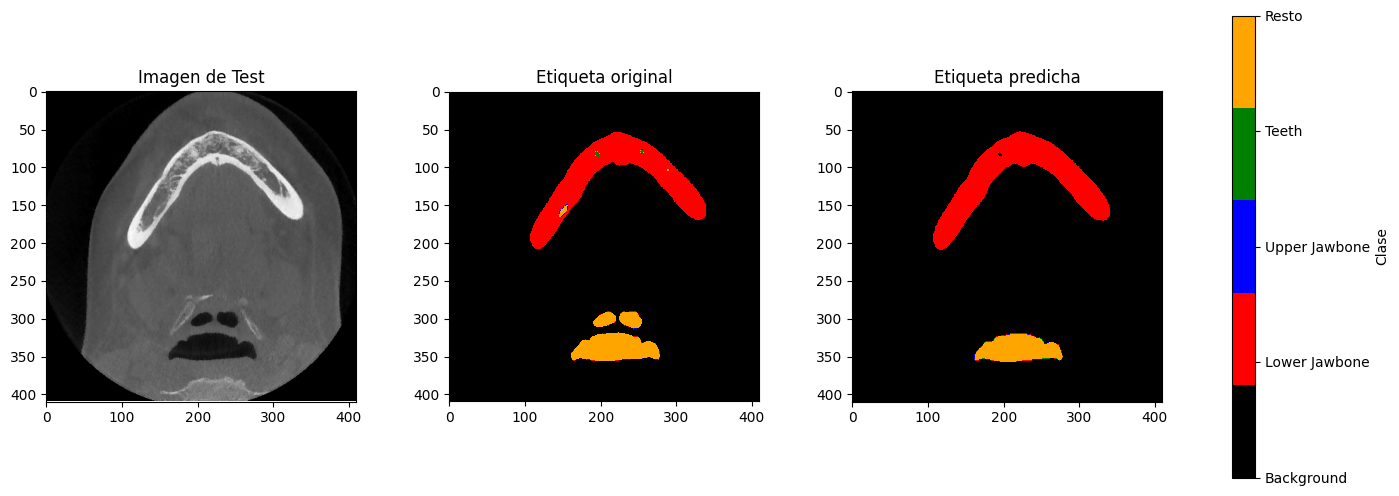

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_051200_0000.nii.gz'
file_name2 = 'ToothFairy2F_051200.nii.gz'
file_name3 = 'ToothFairy2F_051200.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, FOLDER_IMAGES_TEST, FOLDER_LABELS_TEST_GT, FOLDER_LABELS_TEST_PREDICTIONS)

/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/imagesTs/ToothFairy2F_051225_0000.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_raw/Dataset003_ToothFairy2/labelsTs/ToothFairy2F_051225.nii.gz
/content/drive/MyDrive/saros/nnUNet/nnUNet_results/Dataset003_ToothFairy2/postprocessing/ToothFairy2F_051225.nii.gz


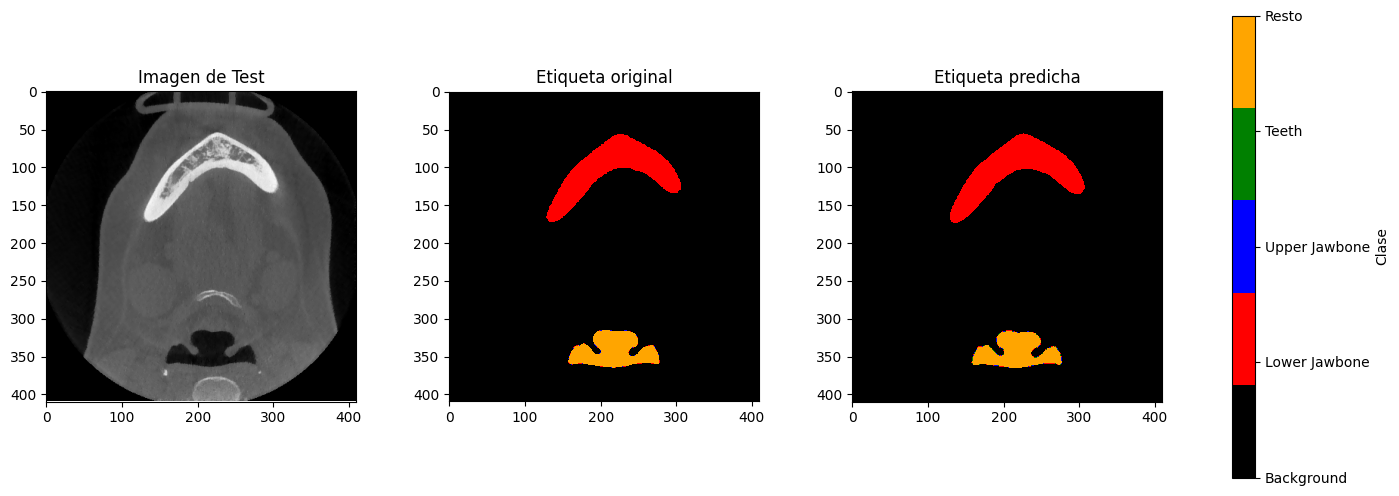

In [ ]:
# Ejemplo de uso de la función
file_name1 = 'ToothFairy2F_051225_0000.nii.gz'
file_name2 = 'ToothFairy2F_051225.nii.gz'
file_name3 = 'ToothFairy2F_051225.nii.gz'
show_two_nii_images(file_name1, file_name2, file_name3, FOLDER_IMAGES_TEST, FOLDER_LABELS_TEST_GT, FOLDER_LABELS_TEST_PREDICTIONS)